In [1]:
using Plots, CSV, DataFrames, QuantEcon, StatsBase, Images, Interpolations

In [16]:
α = 0.64
δ = 0.025
θ = 1.43
s = 0.35
ne = 2

# Asset
amin = 0.0
amax = 40.0
curv = 1.7
na = 101 # number of asset grids
agrid = [amin + amax * ((ia-1)/(na-1)) ^ curv for ia in 1:na];

# Productivity
ρx = 0.929
σx = 0.227
nz = 61 # number of labor prod shocks
ezgrid = exp.(range(-3 * σx, 3 * σx, length = nz));
mc = tauchen(nz, ρx, σx * sqrt(1 - ρx ^ 2), 0);
Π = mc.p;
SSprob = stationary_distributions(mc)[1];

In [17]:
HR = zeros(ne,na,nz)
AS = zeros(ne,na,nz)
μ = zeros(ne,na,nz)

HR[1,:,:] = convert(Matrix, CSV.read("./output/twoskills/HRU.csv", DataFrame))
HR[2,:,:] = convert(Matrix, CSV.read("./output/twoskills/HRS.csv", DataFrame))
AS[1,:,:] = convert(Matrix, CSV.read("./output/twoskills/ASU.csv", DataFrame))
AS[1,:,:] = convert(Matrix, CSV.read("./output/twoskills/ASS.csv", DataFrame))
μ[1,:,:] = convert(Matrix, CSV.read("./output/twoskills/MUU.csv", DataFrame))
μ[2,:,:] = convert(Matrix, CSV.read("./output/twoskills/MUS.csv", DataFrame));

In [18]:
Lu = sum([ez * sum(μ[1,:,iz] .* HR[1,:,iz]) for (iz, ez) in enumerate(ezgrid)])
Ls = sum([ez * sum(μ[2,:,iz] .* HR[2,:,iz]) for (iz, ez) in enumerate(ezgrid)])
K = sum([sum(μ[:,ia,:] .* a) for (ia, a) in enumerate(agrid)])

L = (s * Lu ^ ((θ-1)/θ) + (1-s) * Ls ^ ((θ-1)/θ)) ^ (θ/(θ-1))
wu = α * (K/L) ^ (1-α) * s * (L/Lu) ^ (1/θ)
ws = α * (K/L) ^ (1-α) * (1-s) * (L/Ls) ^ (1/θ);

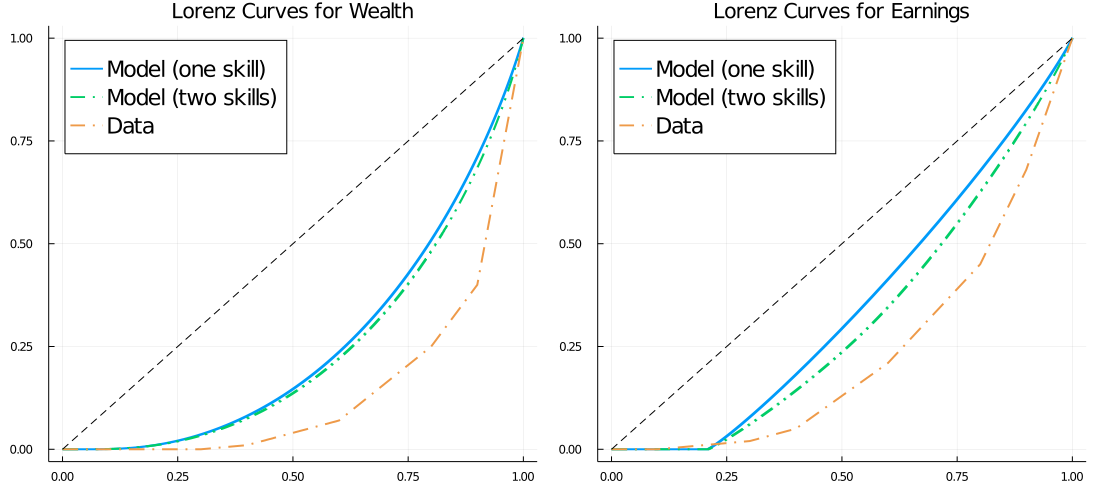

In [19]:
Data_Lorenza = [0.0, 0.0, 0.0, 0.0, 0.01, 0.04, 0.07, 0.16, 0.25, 0.4, 1.0];
Data_Lorenze = [0.0, 0.0, 0.01, 0.02, 0.05, 0.13, 0.21, 0.33, 0.45, 0.68, 1.0];

lorenz_one = CSV.read("./output/oneskill/lorenz_one.csv", DataFrame);
wlth_one = lorenz_one[:,1]
earn_one = lorenz_one[:,2]

smpu = [sample(1:na, weights(μ[1,:,iz]./sum(μ[1,:,iz])), floor(Int32, SSprob[iz]*100000)) for iz in 1:nz]
smps = [sample(1:na, weights(μ[2,:,iz]./sum(μ[2,:,iz])), floor(Int32, SSprob[iz]*100000)) for iz in 1:nz]
wlthu = [agrid[ia] for smp in smpu for ia in smp]
wlths = [agrid[ia] for smp in smps for ia in smp]
earnu = [wu * ezgrid[iz] * HR[1,ia,iz] for (iz, smp) in enumerate(smpu) for ia in smp]
earns = [ws * ezgrid[iz] * HR[2,ia,iz] for (iz, smp) in enumerate(smps) for ia in smp]
wlth = sort(append!(wlthu, wlths))
earn = sort(append!(earnu, earns));

l = @layout [a b]
p1 = plot(range(0,1,length=length(wlth_one)), cumsum(wlth_one)./sum(wlth_one), label="Model (one skill)", lw=2)
plot!(p1, range(0.0,1.0,length=length(wlth)), cumsum(wlth) ./ sum(wlth), label="Model (two skills)", linestyle=:dashdotdot,
    legend=:topleft, legendfontsize=15, lw=2, title="Lorenz Curves for Wealth", color="springgreen3")
plot!(p1, 0.0:0.1:1.0, Data_Lorenza, linestyle=:dashdot, label="Data", lw=2, color=:tan2)

plot!(p1, 0:0.1:1, 0:0.1:1, color=:black, lw=1, label="", linestyle=:dash)
p2 = plot(range(0,1,length=length(earn_one)), cumsum(earn_one)./sum(earn_one), label="Model (one skill)", lw=2)
plot!(range(0.0,1.0,length=length(earn)), cumsum(earn) ./ sum(earn), color="springgreen3", label="Model (two skills)",
    legend=:topleft, legendfontsize=15, lw=2, title="Lorenz Curves for Earnings", linestyle=:dashdotdot)
plot!(p2, 0.0:0.1:1.0, Data_Lorenze, linestyle=:dashdot, label="Data", lw=2, color=:tan2)
plot!(p2, 0:0.1:1, 0:0.1:1, color=:black, lw=1, label="", linestyle=:dash)
plot(p1, p2, size=(nz*18,nz*8), fmt=:png)

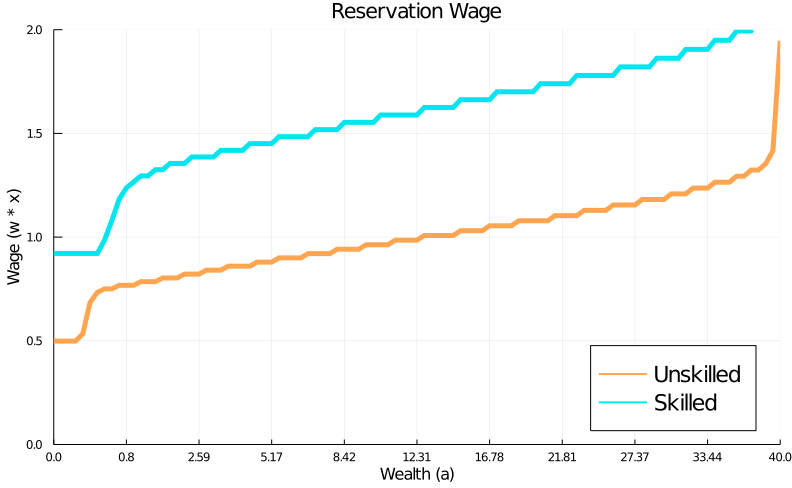

In [21]:
# reservation wage
rw = zeros(Int64, ne,na);
tmprw = [findfirst(x->x>0, transpose(HR[1,:,:])[:,ia]) for ia in 1:na];
tmprw[findall(x->x==nothing, tmprw)] .= nz
rw[1,:] .= tmprw

plot(1:na, wu .* ezgrid[rw[1,:]], color=:tan1, lw=5, label="Unskilled",
    legend=:bottomright, legendfontsize=15, ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png,xlabel="Wealth (a)",
    ylim=(0,2), xlim=(1,na), title = "Reservation Wage", size=(na*7.85,nz*8))

tmprw = [findfirst(x->x>0, transpose(HR[2,:,:])[:,ia]) for ia in 1:na];
tmprw[findall(x->x==nothing, tmprw)] .= nz
rw[2,:] .= tmprw

plot!(1:na, ws .* ezgrid[rw[2,:]], color=:turquoise2, lw=5, label="Skilled",
    legend=:bottomright, legendfontsize=15, ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)") 

In [41]:
RRu = sort(100 .* [(ezgrid[rw[1,ia]] - ezgrid[iz]) / ezgrid[iz] for (iz, smp) in enumerate(smpu) for ia in smp])
RRs = sort(100 .* [(ezgrid[rw[2,ia]] - ezgrid[iz]) / ezgrid[iz] for (iz, smp) in enumerate(smps) for ia in smp])
#RR = sort(append!(RRu, RRs));

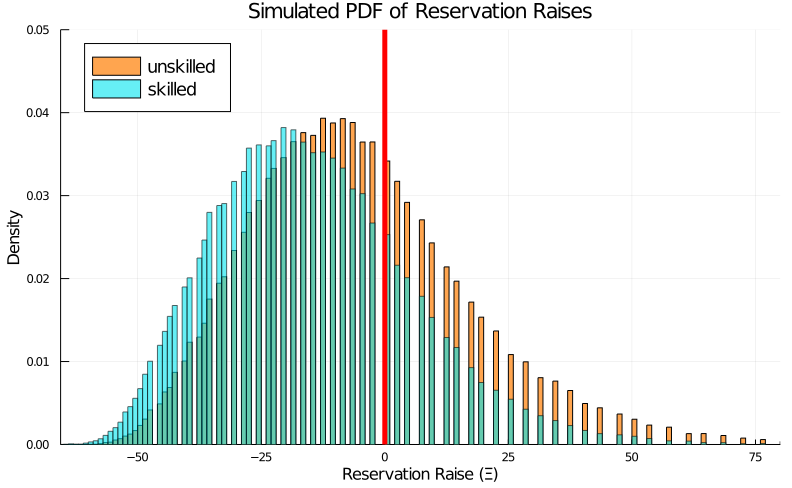

In [43]:
plot(xlabel="Reservation Raise (Ξ)", ylabel="Density", xlim=(RR[1], 80), ylim=(0,0.05),
    size=(na*7.85,nz*8), title="Simulated PDF of Reservation Raises", fmt=:png, legend=:topleft, legendfontsize=12)
histogram!(RRu, label="unskilled", color="tan1", normalize=true, bins=200)
histogram!(RRs, label="skilled", color="turquoise2", alpha=0.6, normalize=true, bins=200)
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=5)

In [53]:
plot(xlabel="Reservation Raise", ylabel="Proportion", xlim=(-60,80), size=(na*7.85,nz*8),
    legend=:bottomright, legendfontsize=15)

plot!(RR, range(0,1,length=length(RR)), label="Total", color="black", lw=3)
plot!(RRu, range(0,sum(μ[1,:,:]),length=length(RRu)), label="Unskilled", color="tan1", lw=3)
plot!(RRs, range(0,sum(μ[2,:,:]),length=length(RRs)), label="Skilled", color="turquoise2", lw=3)
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=3)

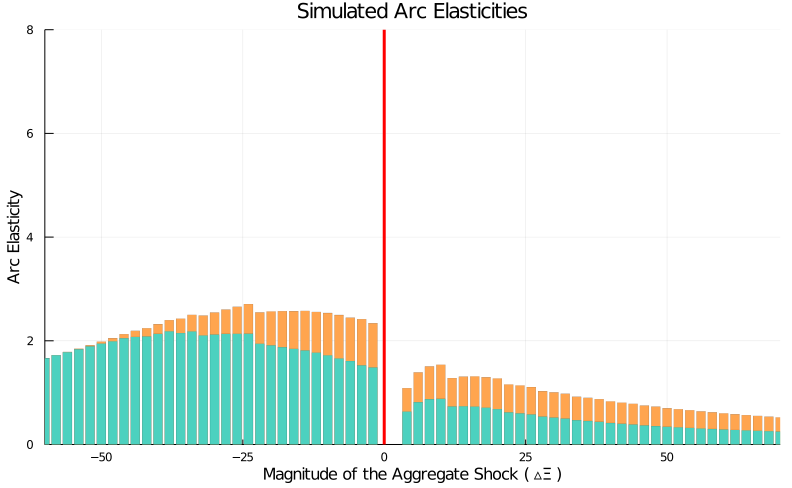

In [56]:
RRcdfu = LinearInterpolation(RRu, range(0,sum(μ[1,:,:]),length=length(RRu)))
RRcdfs = LinearInterpolation(RRs, range(0,sum(μ[2,:,:]),length=length(RRs)))

arcu = [100 * (RRcdfu(r)-RRcdfu(eps())) / RRcdfu(eps()) / r for r in -60:2:70]
arcs = [100 * (RRcdfs(r)-RRcdfs(eps())) / RRcdfs(eps()) / r for r in -60:2:70]
bar(-60:2:70, arcu, color=:tan1, lw=0.1, title = "Simulated Arc Elasticities", ylabel="Arc Elasticity",
    label="", ylim=(0,8), xlim=(-60, 70), xlabel="Magnitude of the Aggregate Shock ( ▵Ξ )", fmt=:png,
    size=(na*7.85,nz*8))
bar!(-60:2:70, arcs, color=:turquoise2, lw=0.1, title = "Simulated Arc Elasticities", ylabel="Arc Elasticity",
    label="", ylim=(0,8), xlim=(-60, 70), xlabel="Magnitude of the Aggregate Shock ( ▵Ξ )", fmt=:png,
    size=(na*7.85,nz*8), alpha=0.7)
plot!([0.0,0.0],[0.0,8.0], label="", color="red", lw=3)